In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf

In [3]:
data = pd.read_csv('prices_ma_and_volforecast.csv')

# Correlation Analysis

C:\Users\kraus\anaconda3\envs\Strat\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kraus\anaconda3\envs\Strat\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kraus\anaconda3\envs\Strat\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


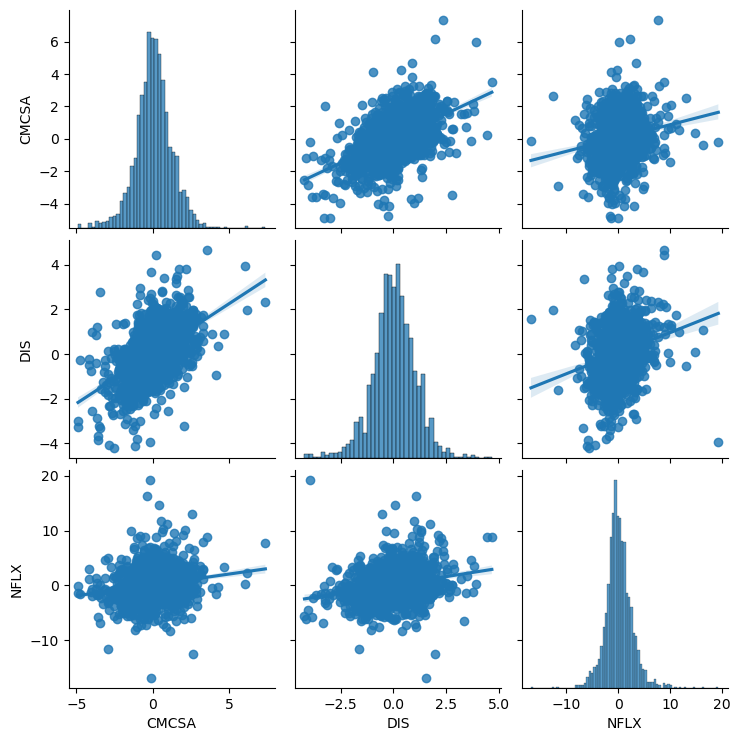

In [12]:
returns_df = data.pivot_table(index='date', columns='symbol', values='returns')
closings_df = data.pivot_table(index='date', columns='symbol', values='close')
sns.pairplot(returns_df, kind='reg')

Not much correlation here... may want to try NVDIA, Intel, Alphabet or something different when implementing trading strategy

In [39]:
print('Returns Correlation:\n', returns_df.corr(), '\n\nClosings Correlation:\n', closings_df.corr())

Returns Correlation:
 symbol     CMCSA       DIS      NFLX
symbol                              
CMCSA   1.000000  0.522484  0.180577
DIS     0.522484  1.000000  0.236153
NFLX    0.180577  0.236153  1.000000 

Closings Correlation:
 symbol     CMCSA       DIS      NFLX
symbol                              
CMCSA   1.000000  0.963303  0.347607
DIS     0.963303  1.000000  0.396838
NFLX    0.347607  0.396838  1.000000


Something to consider: High correlation between DIS and CMSCA closing prices

In [40]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error

In [192]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        # Append close price to y        
        y.append(data[i+seq_length, 3])  # Assuming close price is in the fourth column (index 3)

        # Extract features excluding column 3 (open price)
        features = np.delete(data[i:i+seq_length], 3, axis=1)
        X.append(features)
        
    return np.array(X), np.array(y)

def train_LSTM(data):
    tf.random.set_seed(7)
    # Normalize features
    data['date'] = pd.to_datetime(data['date'])
    data['date'] = data['date'].astype(np.int64) // 10**9  # Convert to Unix timestamp
    data = data.bfill()#(method='ffill')
    
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data[['close', 'open', 'volume',  'returns']])#, 'date', 'forecasted_volatility']]), #'10-Day MA', '20-Day MA', '30-Day MA']]) # remove symbol column before calling function
    sequence_length = 60  # You can adjust this as needed
    X, y = create_sequences(data_scaled, sequence_length)
    
    # Split data into training and testing sets
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Model Creation
    model = Sequential([
        LSTM(units=128, return_sequences=True, input_shape=(sequence_length, X_train.shape[2])),
        LSTM(units=64, return_sequences=True),
        LSTM(units=32),
        #Dropout(0.2),
        Dense(units=X_train.shape[2])
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    # Train the model
    model.fit(X_train, y_train, epochs=1) # epochs may need to be be adjusted
    
    train_loss = model.evaluate(X_train, y_train, verbose=0)
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    print(f'Train Loss: {train_loss}')
    print(f'Test Loss: {test_loss}')
    
    # Make predictions
    y_pred = model.predict(X_test)

    y_pred_inv = scaler.inverse_transform(y_pred)
    y_test_inv = scaler.inverse_transform(y_test)
    
    # Plotting prices
    # Get the length of the training set
    train_len = len(X_train)

    # Plotting
    # Get the length of the training set
    train_len = len(X_train)
    
    # Plotting
    plt.figure(figsize=(16, 6))
    plt.title('Model')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    
    # Plot training data
    plt.plot(data.index[:train_len], data['close'][:train_len], label='Train')
    
    # Plot validation data
    plt.plot(data.index[train_len:], data['close'][train_len:], label='Val')
    
    # Plot predictions
    plt.plot(data.index[train_len+60:train_len+len(y_pred_inv)+60], y_pred_inv[:, 0], label='Predictions')
    
    plt.legend(loc='upper right')
    plt.show()

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'RMSE: {rmse}')


In [ ]:
data_to_be_trained = data[data['symbol']=='NFLX']
train_LSTM(data_to_be_trained)

C:\Users\kraus\AppData\Local\Temp\ipykernel_30076\1761855416.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])
C:\Users\kraus\AppData\Local\Temp\ipykernel_30076\1761855416.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = data['date'].astype(np.int64) // 10**9  # Convert to Unix timestamp


 8/43 [====>.........................] - ETA: 7s - loss: 0.0820